# Data to public database

# Purpose
In order to make this research reproducible the data used will be stored at [Mendeley Data](https://data.mendeley.com/):
* MDL model test roll decay with KVLCC2
* FNPF roll decay with KVLCC2
* Ikeda section results (From manual digitalization)

# Methodology
* Load
* Cut
* Fit
* save

# Setup

In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')
from reports.paper_writing import save_fig

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
from copy import deepcopy
import joblib
from rolldecayestimators import measure
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
import scipy
from sklearn.pipeline import Pipeline
#from reports import mdl_results

## Load meta data from MDL

In [4]:
def load():
    db = database.get_db()

    sql = """
    SELECT * from run
    INNER JOIN loading_conditions
    ON (run.loading_condition_id = loading_conditions.id)
    INNER JOIN models
    ON (run.model_number = models.model_number)
    INNER JOIN ships
    ON (run.ship_name = ships.name)
    WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
    """
    df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
    df_rolldecays['rho']=1000
    df_rolldecays['g']=9.81
    df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
    df_rolldecays.set_index('id', inplace=True)

    df_rolldecays['ship_speed'].fillna(0, inplace=True)
    
    df_rolldecays=df_rolldecays.loc[[21337,21338,21340,]].copy()
    df_rolldecays['paper_name'] = np.arange(len(df_rolldecays)) + 1

    return df_rolldecays

df_rolldecays = load()

## Load data from Motions:

In [5]:
file_paths = [
    '../data/external/kvlcc2_rolldecay_0kn',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large2',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large_5deg',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large_ikeda',
    '../data/external/kvlcc2_rolldecay_15-5kn_ikeda_dev',
]
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)

mask_0 = (df_parameters['vm_s'].round(5) == 0)
df_parameters.loc[mask_0,'id'] = 21338  # MDL DB run id
df_parameters.loc[~mask_0,'id'] = 21340

In [6]:
mask_visc = (df_parameters[['b4l','b4q']] > 0).any(axis=1)
df_parameters.loc[mask_visc]

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_15-5kn_const_large_ikeda,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.00,-5.0,1.00,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.000000e+00,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.000000e+00,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,30.0,0.1,0.1,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.00,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0
kvlcc2_rolldecay_15-5kn_ikeda_dev,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00004,1000.0,1000.0,0.0,0.0,2.0,2.0,1.0,1.0,0.25,-2.0,0.25,NaN,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.20,0.3,9.80665,0.0,0.0,0.002,1.000000e-07,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,600.0,600.0,1.000000e-07,TRAN,24.0,24.0,30.0,6.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,30.0,1.0,1.0,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.25,2.0,0.966976,0.000001,0.000001,0.0,2.0,-2.0,0.2735,0.0001,0.0,21340.0


In [7]:
df_parameters.loc[~mask_visc]

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.957280e+00,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21338.0
kvlcc2_rolldecay_15-5kn_const_large,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.7,-5.0,0.7,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.7,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0
kvlcc2_rolldecay_15-5kn_const_large_5deg,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0


## Load time series from Motions

In [8]:
def find_t_max(X, phi_max):

    Xs = X.copy()
    Xs.index = pd.TimedeltaIndex(X.index, unit='s')
    X_ = Xs.abs().resample('5S').max()
    X_.index = X_.index.total_seconds()
    mask = X_['phi'] < phi_max
    
    X_small = X_.loc[mask]
    if len(X_small) > 0:
        t_max = X_small.iloc[0].name
    else:
        t_max = X.index[-1]
    
    return t_max

In [9]:
time_series = helpers.load_time_series(df_parameters=df_parameters)
time_series_raw = deepcopy(time_series)

phi_max = np.deg2rad(3.5)

for key,df in time_series.items():
    
    if df.mean().abs()['V1'] > 0.01:
        
        phi1d_limit = 10**-2
        index0 = (df['phi1d'].abs() > phi1d_limit).argmax()
        X = df.iloc[index0:].copy()
        t_max = find_t_max(X=X, phi_max=phi_max)
        mask = X.index <= t_max
        X = X.loc[mask]
        
        time_series[key] = X

## Save raw Motions datasets 

In [39]:
interesting = ['phi','phi1d','phi2d','V1']

save_runs = [
'kvlcc2_rolldecay_0kn',
'kvlcc2_rolldecay_15-5kn_const_large2',
'kvlcc2_rolldecay_15-5kn_ikeda_dev',
]

for key in save_runs:
    
    df_save = time_series[key][interesting].copy()
    save_file_name = 'fnpf_%s.csv' % key
    save_path = os.path.join('../data/processed/roll decay KVLCC2', save_file_name)
    df_save.to_csv(save_path)
    
df_parameters_save = df_parameters.loc[save_runs].copy()
save_path = os.path.join('../data/processed/roll decay KVLCC2', 'fnpf_parameters.csv')
df_parameters_save.to_csv(save_path)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


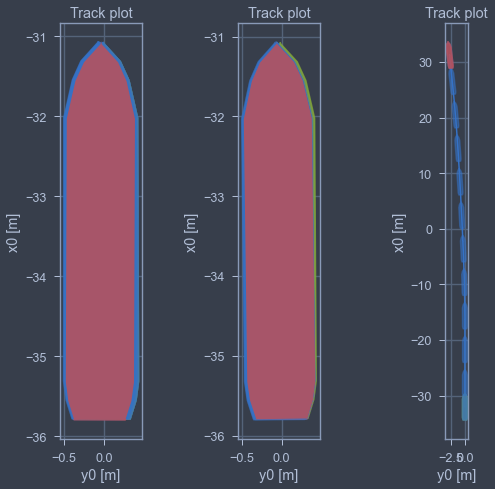

In [16]:
db = database.get_db()

fig,axes=plt.subplots(ncols=len(df_rolldecays))
for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.track_plot(ax)
    
plt.tight_layout()

## Save raw MDL datasets

In [40]:
def save_run(run, save_dir='../data/processed/roll decay KVLCC2'):
    
    renamers = {
        'modelpos/xm' : 'x',
        'modelpos/ym' : 'y',
        'modelpos/zm' : 'z',
        'modelpos/yawm' : 'psi',
    }
    
    renamers_units = {
        'ModelPos/Xm' : 'x',
        'ModelPos/Ym' : 'y',
        'ModelPos/Zm' : 'z',
        'ModelPos/Yawm' : 'psi',
    }
    
    df = run.df.copy()
    df.rename(columns = renamers, inplace=True)
    units = dict(run.units)
    
    for old,new in renamers_units.items():
        units[new] = units.pop(old)    
    units = pd.Series(units)
    
    interesting = ['x','y','z','phi','theta','psi']
    df_save = df[interesting].copy()
    units_save = units[interesting].copy()
    
    save_file_name = 'model_test_%s.csv' % run.id
    save_path = os.path.join(save_dir, save_file_name)
    df_save.to_csv(save_path)
    
    save_path_units = os.path.join(save_dir, 'model_test_units.csv')
    units_save.to_csv(save_path_units)

In [41]:
for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    save_run(run)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
